In [1]:
import scipy as sp
import scipy.integrate as spint8
import GWGen; from GWGen import WFGenerator
import pyAnalyticFluxes as pyan
from GWGen.WFGenerator import *
from few.utils.utility import get_separatrix
from few.trajectory.inspiral import EMRIInspiral
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyAnalyticFluxes as pyan
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# set initial parameters
M = 1e6
m = 1e1
mu = 3.4e-17
a = 0.9
p0 = 10.0
e0 = 0.2
iota0 = 0.0
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.8
qK = 0.2
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 10.0

alphaval = alphavalue(M,mu)
print(r"alpha = {0}".format(alphaval))


use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "npoints": 200,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

traj = PNTraj()
few_traj = EMRIInspiral(func="pn5")

alpha = 0.25442669409345564


Integration halted before ending time. Reasons: Separatrix reached!
exit reason Separatrix reached!    last p 2.6120575929039274
Integration halted before ending time. Reasons: Separatrix reached!
exit reason Separatrix reached!    last p 2.7098633811732964


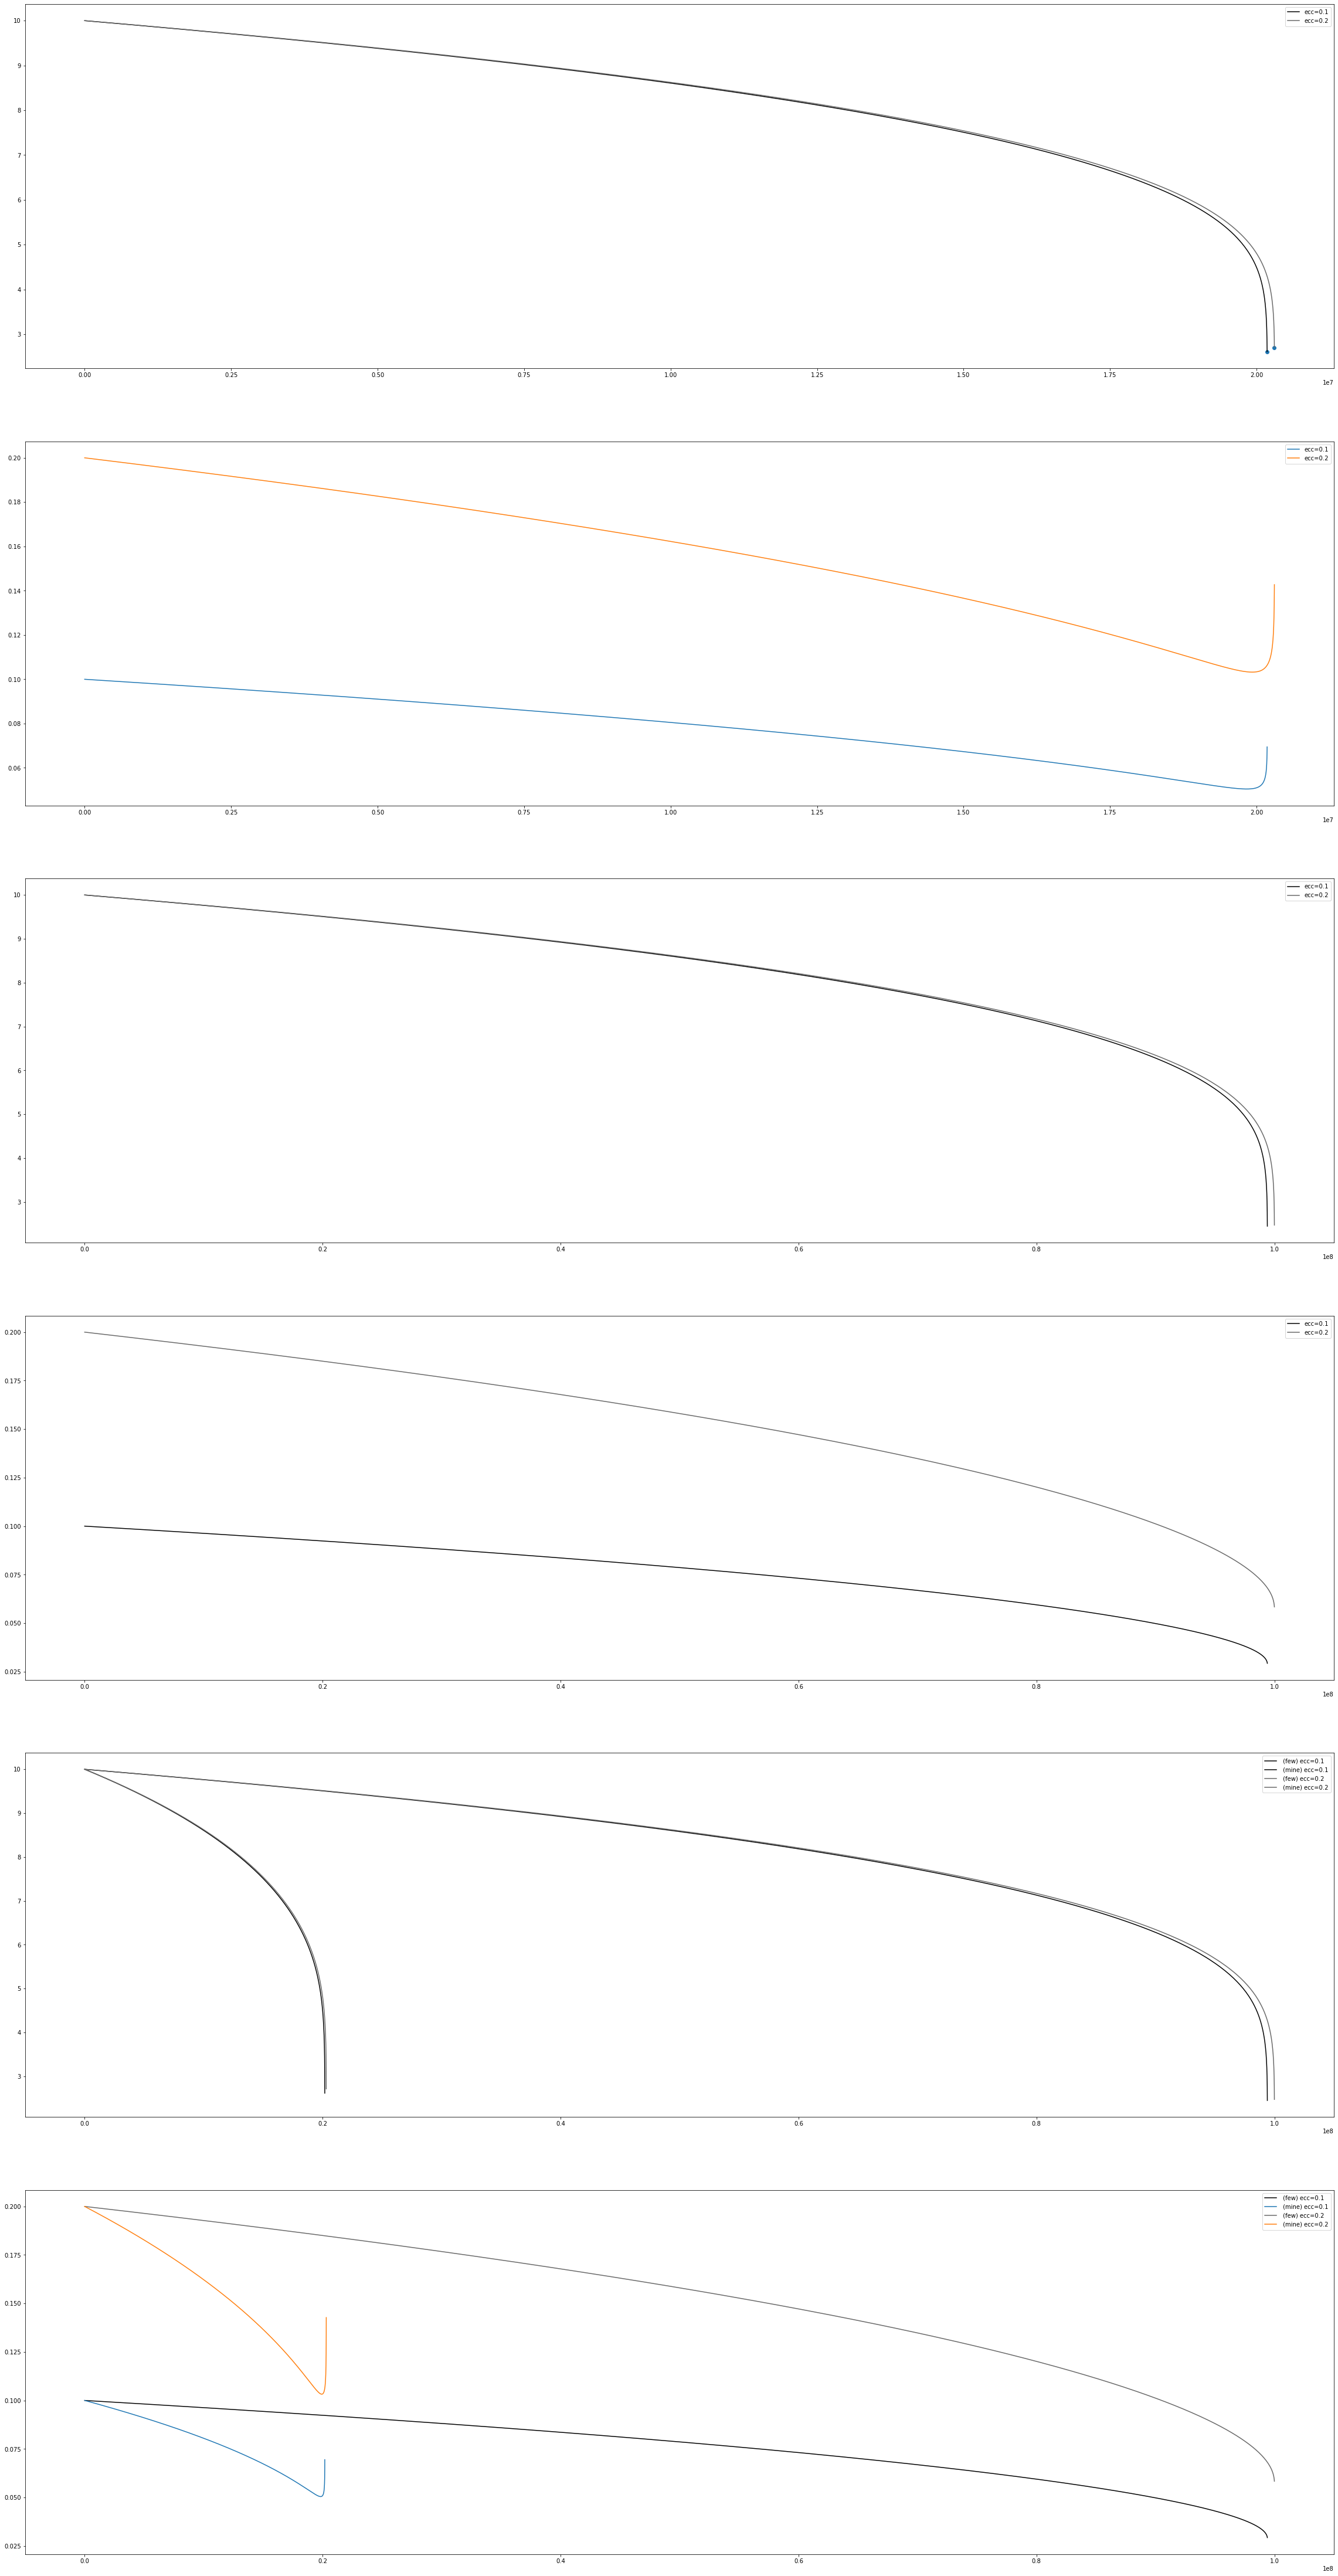

In [12]:
traj.dense_output=True
traj.separatrix_cutoff = get_separatrix(a,e0,1.)+0.01
fig,axes = plt.subplots(6,1,figsize=(40,80))
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items())
cols = [name for hsv, name in by_hsv]
eccs = np.arange(0.1,0.3, 0.1)
separatrix_list = np.ones_like(eccs)
last_times = np.ones_like(eccs)

for inx,ec in enumerate(eccs):
    ec = int(ec*100)/100
    #few
    fewres = few_traj(1e6,10,0.9,10,ec,1.,T=T,**inspiral_kwargs)
    axes[2].plot(fewres[0], fewres[1], label="ecc={0}".format(ec), color=cols[inx])
    axes[2].legend()
    axes[3].plot(fewres[0], fewres[2], label="ecc={0}".format(ec), color=cols[inx])
    axes[3].legend()
    
    #mine
    res = traj(1e6,10,0.9,10,ec,1,T=T,npoints=inspiral_kwargs['npoints'])
    print("exit reason {0}    last p {1}".format(traj.exit_reason, res[1][-1]))
    t,p,e = res[0:3]
    separatrix_list[inx] = traj.separatrix_cut
    last_times[inx] = t[-1]
    axes[0].plot(t,p,label="ecc={0}".format(ec),color=cols[inx])
    axes[1].plot(t,e,label="ecc={0}".format(ec))
    axes[0].legend(labelcolor="Black")
    axes[1].legend()
    
    axes[4].plot(fewres[0], fewres[1], label=" (few) ecc={0}".format(ec), color=cols[inx])
    axes[4].plot(t,p,label=" (mine) ecc={0}".format(ec),color=cols[inx])
    axes[5].plot(fewres[0], fewres[2], label=" (few) ecc={0}".format(ec), color=cols[inx])
    axes[5].plot(t,e,label=" (mine) ecc={0}".format(ec))
    axes[4].legend()
    axes[5].legend()

axes[0].scatter(last_times, separatrix_list)



In [3]:
e0=0.
p0=10
y0=[p0,e0,0,0]
npoints=200

fun = PN(1e6,10)
t_start = 0
t_stop = 11* YRSID_SI / (M * MTSUN_SI)
t_res = t_stop/npoints
t_span = (t_start, t_stop)
t_dom = np.arange(t_start, t_stop, t_res)
max_step_size = t_span[-1]/npoints
init_sep = get_separatrix(0.9,e0,1.)
fun.separatrix_cutoff = get_separatrix(a,e0,1.)+0.1

class event_holder:
    pass
holder = event_holder()
holder.exit_reason=None

def __integration_event_tracker_eccentricity(_, y_vec):
    ecc = y_vec[1]
    #define a function which is has a zero at e=1, a zero at the smallest negative float, and positive on the range [0,1)
    eps = np.finfo(float).eps
    x_shift = (1-eps**2)/(2*(eps+1))
    y_shift = (eps+x_shift)**2
    res = y_shift - (ecc-x_shift)**2
    if res<=0:
        holder.exit_reason = "Eccentricity exceeded bounds"
    return res

def __integration_event_tracker_semilatus_rectum(_, y_vec):
    p = y_vec[0]
    res = p-fun.separatrix_cutoff
    if res<=0:
        holder.exit_reason = "Separatrix reached!"
    return res

def __integration_event_tracker_pFlux(_, y_vec):
    Eflux =fun.UndressedpFlux(y_vec[1],y_vec[0]).value
    res = -Eflux
    if res<=0:
        holder.exit_reason="PN p flux larger than zero! Breaking."
    return res
def __integration_event_tracker_eFlux(_, y_vec):
    p,e = y_vec[:2]
    if e<10**(-10):
        Lflux=0
    else:
        Lflux = fun.UndressedeFlux(e,p).value
    res = -Lflux
    if res<0:
        holder.exit_reason="PN e flux larger than zero! Breaking."
    if e==0:
        return np.finfo(float).eps
    return res

__integration_event_tracker_eccentricity.terminal=True
__integration_event_tracker_semilatus_rectum.terminal=True
__integration_event_tracker_pFlux.terminal=True
__integration_event_tracker_eFlux.terminal=True

__integration_event_trackers = [__integration_event_tracker_eccentricity,
                                                        __integration_event_tracker_semilatus_rectum,
                                                        __integration_event_tracker_pFlux,
                                                        __integration_event_tracker_eFlux]

aa=time.time()
res=solve_ivp(fun, t_span, y0, method="DOP853", dense_output=True,events = __integration_event_trackers, max_step = max_step_size)
print(time.time()-aa)
print(holder.exit_reason)

1.038459300994873
Separatrix reached!


In [11]:
res["sol"](res['t'][-1])

array([2.42088304e+00, 0.00000000e+00, 8.62013265e+05, 6.15460701e+05])

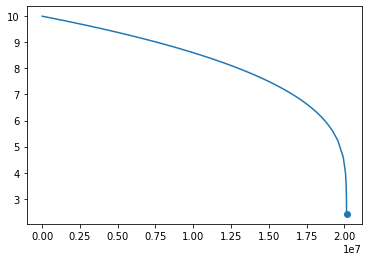

In [4]:
t = res["t"]
p,e,_,_ = res['y']
sol = res['sol']
plt.plot(t,p)
plt.scatter(t[-1], fun.separatrix_cutoff)

In [48]:
print(fun(0,[3,e0,0,0]))

[-5.876512929890433, 1.2549359822694266e-10, 0.16403794793337825, 0.055782323922449785]
-5.876365095799315 m / s


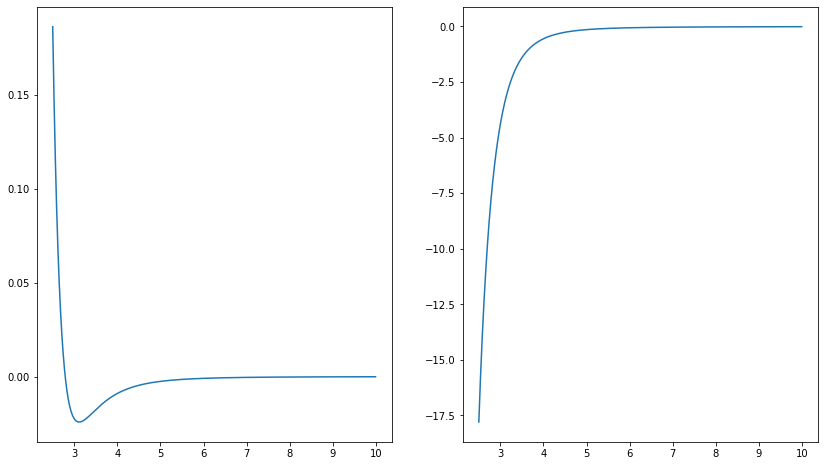

In [101]:
dom = np.arange(2.5,10,0.01)
ran1 = [pyan.pydEdt(0.9,p,0.5,1.,10,10) for p in dom]
ran2 = [pyan.pydpdt(0.9,p,0.5,1.,10,10) for p in dom]
fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(dom,ran1)
ax[1].plot(dom,ran2)

In [132]:
cl = Kerr()
p = 5
e = 0.8
Ed = pyan.pydEdt(0.9,p,e,1.,10,10)
Ld = pyan.pydLdt(0.9,p,e,1.,10,10)
Pd = pyan.pydpdt(0.9,p,e,1.,10,10)
ed = pyan.pydedt(0.9,p,e,1.,8,10)
dEde = cl.dEde()(e,p)
dEdp = cl.dEdp()(e,p)
dLde = cl.dLde()(e,p)
dLdp = cl.dLdp()(e,p)
H = dLdp*dEde - dLde*dEdp
re1 =dEdp*Pd + dEde*ed
re2 = Ed
print("From Pd,ed    {0} \n from E     {1}".format(re1,re2))
print("\n dEde {0} \n dEdp {1} \n dLde {2} \n dLdp {3}".format(dEde, dEdp, dLde, dLdp))

From Pd,ed    0.0035851022578086496 
 from E     -0.0006520755372381576

 dEde 0.14958476802871093 
 dEdp 0.006679676256558984 
 dLde 0.3570054853647694 
 dLdp 0.17689765593572263


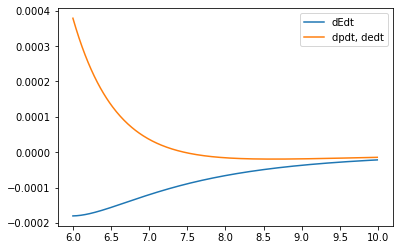

In [151]:
res1 = lambda e,p: pyan.pydEdt(0.9,p,e,1.,10,10)
res2 = lambda e,p: cl.dEdp()(e,p)*pyan.pydpdt(0.9,p,e,1.,10,10) + cl.dEde()(e,p)*pyan.pydedt(0.9,p,e,1.,8,10)
dom = np.arange(6,10,0.01)
e0 =0.9
ran1 = [res1(e0, i) for i in dom]
ran2 = [res2(e0,i) for i in dom]
plt.plot(dom,ran1, label="dEdt")
plt.plot(dom,ran2, label="dpdt, dedt")
plt.legend()